In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn

## Data Generation

In [2]:
# Data Generation
sequ_length = 300
t = np.linspace(1,300,300)
x1 = np.zeros(301)
x2 = np.zeros(301)
y = np.zeros(300)
u = np.concatenate((np.zeros(10),np.ones(10),np.zeros(10),-1*np.ones(10),
                    np.zeros(10),1.5*np.ones(20),np.zeros(20),1.5*np.ones(20),np.zeros(20),-1.5*np.ones(20),
                    np.zeros(20),-2.5*np.ones(20),np.zeros(20),2*np.ones(40),np.zeros(50)), axis=None)

for i in range(sequ_length):
    x1[i+1]=1.145*x1[i]-0.549*x2[i]+0.584*u[i]
    x2[i+1]=x1[i]/(1+0.01*pow(x2[i],2))+(0.181/0.549)*u[i]
    y[i]=4*np.tanh(0.25*x1[i])


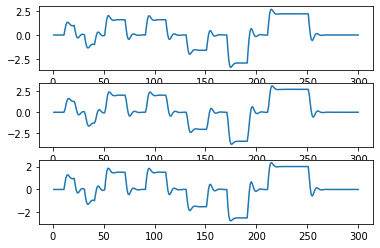

In [3]:
fig, axs = plt.subplots(3)
axs[0].plot(t,x1[:-1])
axs[1].plot(t,x2[:-1])
axs[2].plot(t,y)

In [4]:
y.resize((sequ_length,1))
u.resize((sequ_length,1))

In [5]:
dtype = torch.FloatTensor
y = Variable(torch.Tensor(y).type(dtype), requires_grad=False)
u = Variable(torch.Tensor(u).type(dtype), requires_grad=False)

## Initialization

In [6]:

state_size = 2
input_size = 1
output_size = 1
RNN_hidden_size = 2
ANN_hidden_size = 2
epochs = 500

learning_rate = 0.01

In [7]:
wi= torch.FloatTensor(RNN_hidden_size,input_size).type(dtype)
wh= torch.FloatTensor(state_size,RNN_hidden_size).type(dtype)
wr= torch.FloatTensor(RNN_hidden_size,state_size).type(dtype)
wh2= torch.FloatTensor(ANN_hidden_size,state_size).type(dtype)
wo= torch.FloatTensor(output_size,ANN_hidden_size).type(dtype)
bh= torch.FloatTensor(RNN_hidden_size,1).type(dtype)
bl= torch.FloatTensor(state_size,1).type(dtype)
bh2= torch.FloatTensor(ANN_hidden_size,1).type(dtype)
bl2= torch.FloatTensor(output_size,1).type(dtype)

init.normal_(wi)
init.normal_(wh)
init.normal_(wr)
init.normal_(wh2)
init.normal_(wo)
init.normal_(bh)
init.normal_(bl)
init.normal_(bh2)
init.normal_(bl2)

wi= Variable(wi,requires_grad=True)
wh= Variable(wh,requires_grad=True)
wr= Variable(wr,requires_grad=True)
wh2= Variable(wh2,requires_grad=True)
wo= Variable(wo,requires_grad=True)
bh= Variable(bh,requires_grad=True)
bl= Variable(bl,requires_grad=True)
bh2= Variable(bh2,requires_grad=True)
bl2= Variable(bl2,requires_grad=True)

In [8]:
print(wi,"\n",wh,"\n",wr,"\n",wh2,"\n",wo,"\n",bh,"\n",bl,"\n",bh2,"\n",bl2)

tensor([[0.0571],
        [0.4010]], requires_grad=True) 
 tensor([[-0.3772, -0.3146],
        [ 0.6525,  0.9476]], requires_grad=True) 
 tensor([[-0.0811, -1.1511],
        [-0.0018, -0.1475]], requires_grad=True) 
 tensor([[-0.5247, -1.9005],
        [-0.1029,  0.2141]], requires_grad=True) 
 tensor([[0.6582, 0.8788]], requires_grad=True) 
 tensor([[2.3321],
        [0.3398]], requires_grad=True) 
 tensor([[ 1.2618],
        [-0.2036]], requires_grad=True) 
 tensor([[ 0.8823],
        [-1.0368]], requires_grad=True) 
 tensor([[0.9820]], requires_grad=True)


## NN Training

In [9]:
logsig = nn.LogSigmoid()

def forward(inputs,state,wi,wh,wr,wh2,wo,bh,bl,bh2,bl2):
    state_f=wh.mm(logsig(wr.mm(state)+wi*inputs+bh))+bl
    out_f=wo.mm(torch.tanh(wh2.mm(state)+bh2))+bl2
    return (out_f,state_f)

In [10]:
loss_func = nn.MSELoss()
optimizer=torch.optim.SGD([wi,wh,wr,wh2,wo,bh,bl,bh2,bl2],lr=learning_rate)

In [11]:
for i in range(epochs):
    total_loss = 0
    state = Variable(torch.zeros((state_size, 1)).type(dtype), requires_grad=False)
    for j in range(sequ_length):
        inputs = u[j]
        target = y[j]
        (predict, state) = forward(inputs,state,wi,wh,wr,wh2,wo,bh,bl,bh2,bl2)
        
        loss = loss_func(target,predict)
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()
        
        state = Variable(state.data, requires_grad=False)
        total_loss += loss
    if i % 10 == 0:
        print("Epoch: {} loss {}".format(i, total_loss))

Epoch: 0 loss 278.4096984863281


C:\Users\yungu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10 loss 28.37948226928711
Epoch: 20 loss 19.667728424072266
Epoch: 30 loss 19.795480728149414
Epoch: 40 loss 19.941020965576172
Epoch: 50 loss 20.092063903808594
Epoch: 60 loss 20.208032608032227
Epoch: 70 loss 20.288013458251953
Epoch: 80 loss 20.336891174316406
Epoch: 90 loss 20.358366012573242
Epoch: 100 loss 20.35561180114746
Epoch: 110 loss 20.33298683166504
Epoch: 120 loss 20.29595375061035
Epoch: 130 loss 20.24972152709961
Epoch: 140 loss 20.198463439941406
Epoch: 150 loss 20.145370483398438
Epoch: 160 loss 20.093074798583984
Epoch: 170 loss 20.04366683959961
Epoch: 180 loss 19.99859046936035
Epoch: 190 loss 19.958446502685547
Epoch: 200 loss 19.923015594482422
Epoch: 210 loss 19.891393661499023
Epoch: 220 loss 19.8624267578125
Epoch: 230 loss 19.835031509399414
Epoch: 240 loss 19.80852699279785
Epoch: 250 loss 19.78253936767578
Epoch: 260 loss 19.756919860839844
Epoch: 270 loss 19.7316837310791
Epoch: 280 loss 19.706880569458008
Epoch: 290 loss 19.682554244995117
Epoch: 

In [12]:
print(wr,"\n",wh,"\n",wi,"\n",bh,"\n",bl,"\n",wo,"\n",wh2,"\n",bh2,"\n",bl2)

tensor([[-0.0811, -1.1511],
        [-0.0018, -0.1475]], requires_grad=True) 
 tensor([[-0.3772, -0.3146],
        [ 0.6525,  0.9476]], requires_grad=True) 
 tensor([[0.0571],
        [0.4010]], requires_grad=True) 
 tensor([[2.3321],
        [0.3398]], requires_grad=True) 
 tensor([[ 1.2618],
        [-0.2036]], requires_grad=True) 
 tensor([[-1.5971,  1.9395]], requires_grad=True) 
 tensor([[-2.4588, -3.9907],
        [ 1.9568,  5.0336]], requires_grad=True) 
 tensor([[-0.0067],
        [-0.2193]], requires_grad=True) 
 tensor([[0.4536]], requires_grad=True)


In [13]:
state_test = Variable(torch.zeros((state_size, 1)).type(dtype), requires_grad=False)
predictions = []
state1 =[]
state2 =[]
state1.append(state_test[0].data.numpy()[0])
state2.append(state_test[1].data.numpy()[0])
for i in range(sequ_length):
    inputs = u[i]
    (pred, state_test) = forward(inputs,state_test,wi,wh,wr,wh2,wo,bh,bl,bh2,bl2)
    predictions.append(pred.data.numpy()[0])
    state1.append(state_test[0].data.numpy()[0])
    state2.append(state_test[1].data.numpy()[0])

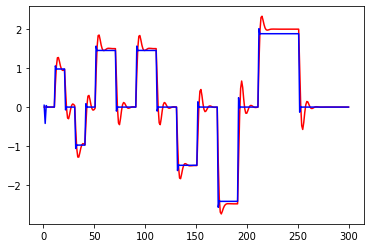

In [14]:
# Y Comparison
plt.plot(t, y.data.numpy(),'r')
plt.plot(t,predictions,'b')
plt.show()

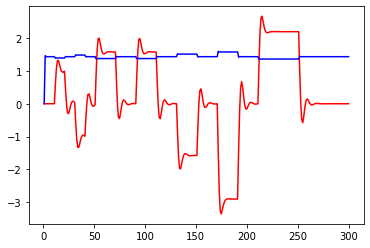

In [15]:
# State 1 Comparison
plt.plot(t,x1[:-1],'r')
plt.plot(t,state1[:-1],'b')

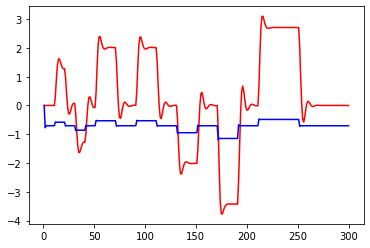

In [16]:
# State 2 Comparison
plt.plot(t,x2[:-1],'r')
plt.plot(t,state2[:-1],'b')

In [17]:
# Optimum Weights from the Research Paper:
wr = torch.tensor([[-0.0340,0.0162],[-0.2375,-0.2529]])
wh = torch.tensor([[-134.8114,0.0261],[-81.8352,-5.2239]])
wi = torch.tensor([[-0.0173],[0.0211]])
bh = torch.tensor([[-0.0023],[0.0001]])
bl = torch.tensor([[67.316],[43.4829]])
wo = torch.tensor([[-5.6543,2.3457]])
wh2 = torch.tensor([[-0.500,0],[0.5,0]])
bh2 = torch.tensor([[0.1812],[0.4369]])
bl2 = torch.tensor([[1.6543]])


In [18]:
# Optimum Weights
wr = torch.tensor([[0.7235,0.7440],[0.1757,-1.0095]])
wh = torch.tensor([[-0.6110,1.0477],[0.5327,-0.5762]])
wi = torch.tensor([[-0.4862],[0.5656]])
bh = torch.tensor([[-2.1229],[-0.9320]])
bl = torch.tensor([[0.8278],[0.1663]])
wo = torch.tensor([[-1.4655,-1.3205]])
wh2 = torch.tensor([[0.0513,1.0482],[-0.9251,0.6009]])
bh2 = torch.tensor([[-0.7163],[2.0583]])
bl2 = torch.tensor([[5.1079e-05]])

wi= Variable(wi,requires_grad=True)
wh= Variable(wh,requires_grad=True)
wr= Variable(wr,requires_grad=True)
wh2= Variable(wh2,requires_grad=True)
wo= Variable(wo,requires_grad=True)
bh= Variable(bh,requires_grad=True)
bl= Variable(bl,requires_grad=True)
bh2= Variable(bh2,requires_grad=True)
bl2= Variable(bl2,requires_grad=True)